In [1]:
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, LSTM, RepeatVector
from keras.layers.wrappers import *
from keras.layers.core import *
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.optimizers import RMSprop
from keras import backend as K

import csv
import os
import time
import sys
import numpy as np
import matplotlib
# matplotlib.use('Agg')
import pylab as plt
from scipy.misc import toimage

import imageio
import cv2
import numpy as np
import numpngw
import pandas as pd 

from IPython.display import HTML

Using TensorFlow backend.


# Test Data Generation Function

In [2]:
GENERATE_DATA = 1 
LOG_DIR = "../../tensorboard/log/"
EPOCH = 150
sequenceLength = 3
setup_name = "clrmvsq_simple_vgg_a"
N_SAMPLES = 1000
BATCHSIZE = 5
ucf_generate_fps = 2  # The fps to sample from the original UCF data to generate the train and val set
data_path = "../../data/UCF/"

batch_size=20
data_type = 'images'
concat=False


In [3]:
import data_seq
data_seq = reload(data_seq)

data = data_seq.DataSet(seq_length=5,class_limit=10)

print data.data[:1], '\n'
print data.classes[:5]
print data.image_shape


[['train', 'ApplyEyeMakeup', 'v_ApplyEyeMakeup_g08_c02', '118']] 

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam']
(224, 224, 3)


In [4]:
generator = data.seq_generator(batch_size, 'train', 'images')

X,y  = next(generator);

print X.shape

images = X[18]
imageio.mimsave('./movie.gif', images)
HTML('<img src="./movie.gif">')

Show 'data' shape:
944
Show 'data' first element:
['train', 'ApplyEyeMakeup', 'v_ApplyEyeMakeup_g08_c02', '118']
Creating train generator with 944 videos.
Recommended steps per epoch = videos/batch_size
(20, 5, 224, 224, 3)


/home/lab.analytics.northwestern.edu/yma/.conda/envs/dl/lib/python2.7/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


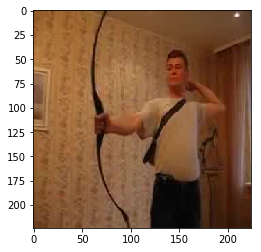

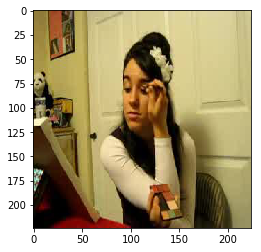

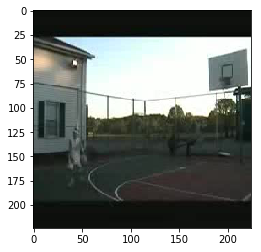

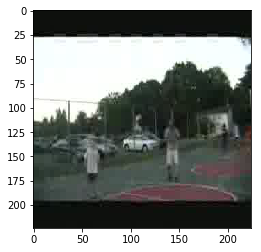

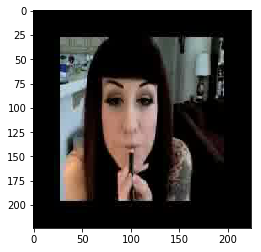

In [5]:
X,y  = next(generator);
for i in range (0,5):
    images = X[i][0]
    plt.imshow(images)
    plt.show()

In [6]:
for _ in range(10):
    X,y  = next(generator);

In [7]:

X,y  = next(generator);

print X.shape

images = X[18]
imageio.mimsave('./movie.gif', images)
HTML('<img src="./movie.gif">')

(20, 5, 224, 224, 3)


# Adjust the saved model

In [8]:
import sys,os,os.path
sys.path.append(os.path.expanduser('/home/lab.analytics.northwestern.edu/yma/git/videodl/seq_inquiry'))
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [9]:
# Examaine model file
from keras.models import load_model

# weights_file = "/home/lab.analytics.northwestern.edu/yma/git/data/checkpoints/ucf_vgg16_seq3_convlstm.040-0.0857.hdf5"

weights_file = "/home/lab.analytics.northwestern.edu/yma/git/data/checkpoints/ucf_vgg16_simple_seq3_convlstm.001-0.03.hdf5"

model = load_model(weights_file)

In [10]:
json_string = model.to_json()

# Test Model Validation

In [11]:
print("--- Start Assembling the Model ---")

inputs = Input(shape=(sequenceLength,224,224,3))

# conved = TimeDistributed(Lambda(MyCNN), input_shape=(sequenceLength,40,40,1)) (inputs)

x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1'), input_shape=(sequenceLength,224,224,3))(inputs)
x = TimeDistributed(MaxPooling2D((2, 2), name='block1_pool'))(x)
# x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1'))(x)
x = TimeDistributed(MaxPooling2D((2, 2), name='block2_pool'))(x)
x = TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1'))(x)
x = TimeDistributed(MaxPooling2D((2, 2), name='block3_pool'))(x)
x = TimeDistributed(Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1'))(x)
x = TimeDistributed(MaxPooling2D((2, 2), name='block4_pool'))(x)
x = TimeDistributed(Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv1'))(x)

# LSTM part
x = TimeDistributed(MaxPooling2D((2, 2), name='block5_pool'))(x)
# x = TimeDistributed(Flatten())(x)

encoded = ConvLSTM2D(filters=100, kernel_size=(3, 3),padding='same', return_sequences=True)(x)

encoder = Model(output=encoded,input=inputs)
# myoptmizer = RMSprop(lr=0.1, decay=1e-4)
# autoencoder.compile(loss='mean_squared_error', optimizer=myoptmizer)
encoder.compile(loss='mean_squared_error', optimizer='RMSprop')

plot_model(encoder, to_file='query_model.png', show_shapes=True)

print('--- Finish Compile and Plot Model ---')

--- Start Assembling the Model ---


/home/lab.analytics.northwestern.edu/yma/.local/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


--- Finish Compile and Plot Model ---


In [12]:
weights_file = "/home/lab.analytics.northwestern.edu/yma/git/data/checkpoints/ucf_simple_vgg16_seq3_convlstm_c5.002-0.0186.hdf5"
encoder.load_weights(weights_file, by_name=True)

In [13]:
# print(X.shape)
# image = X[0][0]
# plt.imshow(image)
# plt.show()

In [15]:
data = data_seq.DataSet(seq_length=3,class_limit=100)
N_samples = 100
ucf_val_generator =  data.seq_generator(N_samples, 'test', 'images')
X,y = next(ucf_val_generator)

prediction = encoder.predict(X)

min_map = {}
for i in range(N_samples):
    mindis = 1<<30
    for j in range(N_samples):
        if  i!=j:
            score = np.linalg.norm(np.subtract(prediction[i],prediction[j]))
#             print(i,j,score,mindis)
            if mindis > score:
                mindis = score
                min_map[i]= j

correct_count = 0
incorrect_count = 0

for i in range(N_samples):
#     print(i, min_map[i], y[i], y[min_map[i]])
    if y[i] == y[min_map[i]]:
        correct_count += 1
    else:
        incorrect_count += 1

print("Correct:", correct_count)
print("Incorrect:", incorrect_count)

Show 'data' shape:
3388
Show 'data' first element:
['test', 'BodyWeightSquats', 'v_BodyWeightSquats_g06_c05', '177']
Creating test generator with 3388 videos.
Recommended steps per epoch = videos/batch_size
('Correct:', 13)
('Incorrect:', 87)
